# Crowdfunding Success Prediction

## Data Preprocessing

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import randint, uniform
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import utils

In [7]:
# load the excel file
df = pd.read_excel('Crowdfunding campaign.xlsx', sheet_name='Sheet1')
df

cid  pre_order_perk  amt_goal  frac_raised  tech_campaign  \
0     71762               0      2500     0.040000              0   
1     72367               0      1500     1.733333              0   
2     73646               1    100000     1.007510              1   
3     74867               1      7000     0.000000              0   
4     82829               1      2000     1.000000              0   
..      ...             ...       ...          ...            ...   
434  242139               1    100000     2.139170              1   
435  242139               1    100000     2.139170              1   
436  242139               1    100000     2.139170              1   
437  250311               1      5000     1.007000              0   
438  250311               1      5000     1.007000              0   

     sbiz_campaign  fixed_fund           state  year_start  iot_plus  delivery  
0                1         0.0        Kentucky        2011       0.0       NaN  
1                0         0.0         Indiana        2012       0.0       NaN  
2                0         0.0       Louisiana        2012       0.0       NaN  
3                1         0.0  North Carolina        2012       0.0       NaN  
4                1         0.0    Pennsylvania        2011       0.0       NaN  
..             ...         ...             ...         ...       ...       ...  
434              0         1.0      California        2013       1.0       NaN  
435              0         1.0      California        2013       1.0       NaN  
436              0         1.0      California        2013       1.0       NaN  
437              1         0.0        Kentucky        2012       0.0       NaN  
438              1         0.0        Kentucky        2012       0.0       NaN  

[439 rows x 11 columns]

In [8]:
# Check for missing values
df.isnull().sum()

cid                 0
pre_order_perk      0
amt_goal            0
frac_raised         0
tech_campaign       0
sbiz_campaign       0
fixed_fund          6
state               0
year_start          0
iot_plus            4
delivery          289
dtype: int64

In [9]:
# find duplicates
df[df.duplicated()]

cid  pre_order_perk  amt_goal  frac_raised  tech_campaign  \
224   71762               0      2500     0.040000              0   
225   72367               0      1500     1.733333              0   
226   72367               0      1500     1.733333              0   
227   72367               0      1500     1.733333              0   
228   73646               1    100000     1.007510              1   
..      ...             ...       ...          ...            ...   
434  242139               1    100000     2.139170              1   
435  242139               1    100000     2.139170              1   
436  242139               1    100000     2.139170              1   
437  250311               1      5000     1.007000              0   
438  250311               1      5000     1.007000              0   

     sbiz_campaign  fixed_fund       state  year_start  iot_plus  delivery  
224              1         0.0    Kentucky        2011       0.0       NaN  
225              0         0.0     Indiana        2012       0.0       NaN  
226              0         0.0     Indiana        2012       0.0       NaN  
227              0         0.0     Indiana        2012       0.0       NaN  
228              0         0.0   Louisiana        2012       0.0       NaN  
..             ...         ...         ...         ...       ...       ...  
434              0         1.0  California        2013       1.0       NaN  
435              0         1.0  California        2013       1.0       NaN  
436              0         1.0  California        2013       1.0       NaN  
437              1         0.0    Kentucky        2012       0.0       NaN  
438              1         0.0    Kentucky        2012       0.0       NaN  

[215 rows x 11 columns]

In [10]:
# drop duplicates
df = df.drop_duplicates()
df

cid  pre_order_perk  amt_goal  frac_raised  tech_campaign  \
0     71762               0      2500     0.040000              0   
1     72367               0      1500     1.733333              0   
2     73646               1    100000     1.007510              1   
3     74867               1      7000     0.000000              0   
4     82829               1      2000     1.000000              0   
..      ...             ...       ...          ...            ...   
219  248410               0      1500     1.088000              0   
220  248622               0     10000     1.005000              0   
221  250311               1      5000     1.007000              0   
222  256062               1      2000     8.188500              1   
223  256198               0      1000     0.000000              0   

     sbiz_campaign  fixed_fund           state  year_start  iot_plus  delivery  
0                1         0.0        Kentucky        2011       0.0       NaN  
1                0         0.0         Indiana        2012       0.0       NaN  
2                0         0.0       Louisiana        2012       0.0       NaN  
3                1         0.0  North Carolina        2012       0.0       NaN  
4                1         0.0    Pennsylvania        2011       0.0       NaN  
..             ...         ...             ...         ...       ...       ...  
219              1         0.0        Illinois        2012       0.0       NaN  
220              1         0.0        New York        2012       0.0       NaN  
221              1         0.0        Kentucky        2012       0.0       NaN  
222              0         0.0         Georgia        2013       0.0       1.0  
223              1         0.0           Maine        2013       0.0       NaN  

[224 rows x 11 columns]

In [11]:
# drop the "delivery" column
df = df.drop(columns=['delivery'])

In [12]:
# drop rows with missing values
df = df.dropna()

## Exploratory Data Analysis

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Describe the data
df.describe()

cid  pre_order_perk       amt_goal  frac_raised  \
count     216.000000      216.000000     216.000000   216.000000   
mean   164216.592593        0.509259   17533.518519     1.801634   
std     41130.626378        0.501076   31481.563736     3.699447   
min     71762.000000        0.000000     500.000000     0.000000   
25%    137707.750000        0.000000    1462.500000     0.008788   
50%    158916.000000        1.000000    5000.000000     1.019715   
75%    194429.500000        1.000000   15000.000000     1.750967   
max    256198.000000        1.000000  200000.000000    25.918080   

       tech_campaign  sbiz_campaign  fixed_fund   year_start   iot_plus  
count     216.000000     216.000000  216.000000   216.000000  216.00000  
mean        0.462963       0.412037    0.212963  2012.648148    0.12037  
std         0.499785       0.493345    0.410353     0.567570    0.32615  
min         0.000000       0.000000    0.000000  2011.000000    0.00000  
25%         0.000000       0.000000    0.000000  2012.000000    0.00000  
50%         0.000000       0.000000    0.000000  2013.000000    0.00000  
75%         1.000000       1.000000    0.000000  2013.000000    0.00000  
max         1.000000       1.000000    1.000000  2013.000000    1.00000

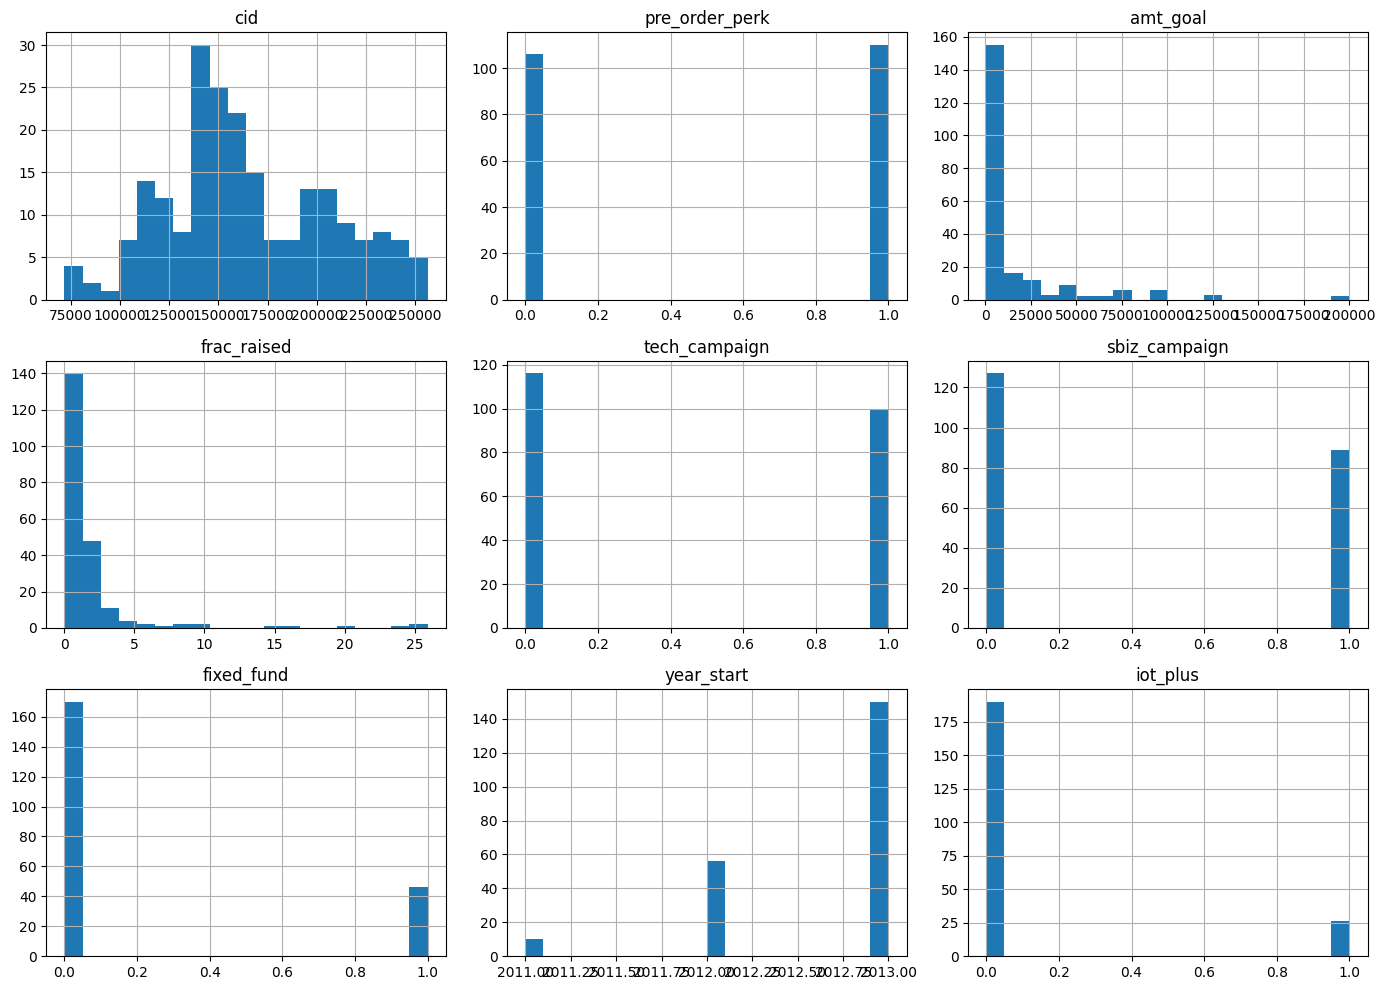

In [15]:
#Inspect the data, check skewness, outliers
df.hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

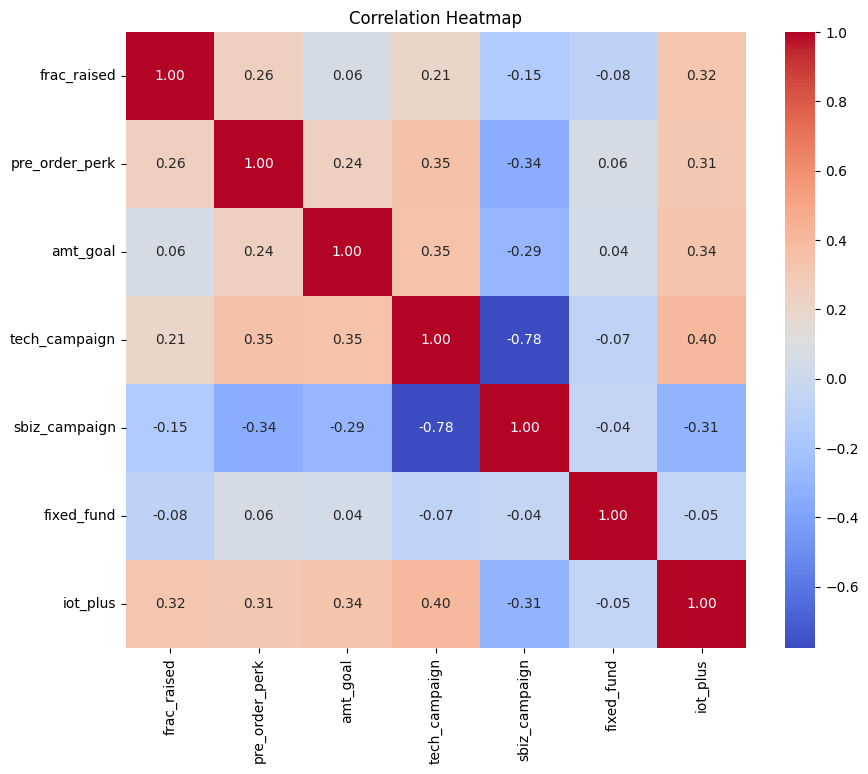

In [16]:
# Correlation heatmap (year and cid are exclued)
plt.figure(figsize=(10, 8))
sns.heatmap(df[["frac_raised", "pre_order_perk", "amt_goal", "tech_campaign", "sbiz_campaign", "fixed_fund", "iot_plus"]].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Feature Engineering

In [ ]:
# Split the data into features and target
X = df.drop(columns=['cid', 'state', 'frac_raised'])
y = df['frac_raised']

### Remove Highly Correlated Features

In [ ]:
# remove columns with high multicollinearity
X_vif = utils.calculate_vif(X, threshold=5)
X = X_vif
X_vif

Removed variables with high VIF:
year_start: 10.02


pre_order_perk  amt_goal  tech_campaign  sbiz_campaign  fixed_fund  \
0                 0      2500              0              1         0.0   
1                 0      1500              0              0         0.0   
2                 1    100000              1              0         0.0   
3                 1      7000              0              1         0.0   
4                 1      2000              0              1         0.0   
..              ...       ...            ...            ...         ...   
219               0      1500              0              1         0.0   
220               0     10000              0              1         0.0   
221               1      5000              0              1         0.0   
222               1      2000              1              0         0.0   
223               0      1000              0              1         0.0   

     iot_plus  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
..        ...  
219       0.0  
220       0.0  
221       0.0  
222       0.0  
223       0.0  

[216 rows x 6 columns]

### Feature Scaling (for linear models)

In [ ]:
# scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

pre_order_perk  amt_goal  tech_campaign  sbiz_campaign  fixed_fund  \
0         -1.018693 -0.478643      -0.928477       1.194557   -0.520181   
1         -1.018693 -0.510482      -0.928477      -0.837130   -0.520181   
2          0.981650  2.625602       1.077033      -0.837130   -0.520181   
3          0.981650 -0.335370      -0.928477       1.194557   -0.520181   
4          0.981650 -0.494563      -0.928477       1.194557   -0.520181   
..              ...       ...            ...            ...         ...   
211       -1.018693 -0.510482      -0.928477       1.194557   -0.520181   
212       -1.018693 -0.239855      -0.928477       1.194557   -0.520181   
213        0.981650 -0.399047      -0.928477       1.194557   -0.520181   
214        0.981650 -0.494563       1.077033      -0.837130   -0.520181   
215       -1.018693 -0.526401      -0.928477       1.194557   -0.520181   

     iot_plus  
0   -0.369922  
1   -0.369922  
2   -0.369922  
3   -0.369922  
4   -0.369922  
..        ...  
211 -0.369922  
212 -0.369922  
213 -0.369922  
214 -0.369922  
215 -0.369922  

[216 rows x 6 columns]

## Model Selection

### Scoring and Cross-Validation

In [ ]:
# Define a custom scorer (mean absolute error)
mae_scorer = make_scorer(mean_absolute_error)

In [ ]:
# Define the cross-validation strategy
cv = LeaveOneOut()

### Linear Regression

In [ ]:
# create a linear regression model
lr_model = LinearRegression()

# evaluate the model
scores = cross_val_score(lr_model, X_scaled, y, scoring=mae_scorer, cv=cv)

# print the mean MAE
scores.mean()

1.8530782722439156

### OLS Statsmodels Output

In [ ]:
# add a constant to the features
X_ols = X.copy()
X_ols = sm.add_constant(X_ols)

# fit the model
ols_model = sm.OLS(y, X_ols)
ols_results = ols_model.fit()

# print the summary
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:            frac_raised   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     6.052
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           7.36e-06
Time:                        19:14:19   Log-Likelihood:                -571.25
No. Observations:                 216   AIC:                             1157.
Df Residuals:                     209   BIC:                             1180.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6386      0.746      0.

### Random Forest

In [ ]:

# create a random forest model
rf_model = RandomForestRegressor(random_state=42)

# evaluate the model
scores = cross_val_score(rf_model, X, y, scoring=mae_scorer, cv=cv)

# print the mean MAE
scores.mean()

2.033330043428781

#### Hyperparameter Tuning

In [ ]:
param_distributions_rf = {
    'n_estimators': randint(100, 1000),  # Number of trees (100 to 1000)
    'max_depth': randint(1, 10),  # Depth of trees (1 to 10)
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required in a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'bootstrap': [True, False],  # Whether to use bootstrapping
}

In [ ]:
# create a random search object
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions_rf,
    n_iter=50,
    scoring=mae_scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

rf_random_search.fit(X, y)

Fitting 216 folds for each of 50 candidates, totalling 10800 fits
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.3s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total ti

RandomizedSearchCV(cv=LeaveOneOut(),
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14802b490>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14801c310>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14801f910>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14802a250>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, response_method='predict'),
                   verbose=2)

In [ ]:
# Print the best parameters and score
print("Best Parameters: ", rf_random_search.best_params_)
print("Best Score: ", rf_random_search.best_score_)

Best Parameters:  {'bootstrap': False, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 879}
Best Score:  2.036822613696899


### AdaBoost

In [ ]:
# define a base model
base_model = DecisionTreeRegressor(max_depth=1, random_state=42)

# create an AdaBoost model
ab_model = AdaBoostRegressor(estimator=base_model, random_state=42)

# evaluate the model
scores = cross_val_score(ab_model, X, y, scoring=mae_scorer, cv=cv)

# print the mean MAE
scores.mean()

1.8503064464896017

#### Hyperparameter Tuning

In [ ]:
param_distributions_ada = {
    'n_estimators': randint(1, 100),  # Number of boosting stages
    'learning_rate': uniform(0.01, 2),  # Shrinkage step size
    #'estimator__max_depth': randint(1, 10),  # Tuning max depth of base decision tree
    #'estimator__min_samples_split': randint(1, 5),  # Min samples to split in the base tree
    #'estimator__min_samples_leaf': randint(1, 5),  # Min samples for leaves
}

In [ ]:
# create a random search object
ada_random_search = RandomizedSearchCV(
    estimator=ab_model,
    param_distributions=param_distributions_ada,
    n_iter=50,
    scoring=mae_scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

ada_random_search.fit(X, y)

Fitting 216 folds for each of 50 candidates, totalling 10800 fits
[CV] END colsample_bytree=0.1874588443936917, gamma=0.30750361334958487, learning_rate=0.307016155031279, max_depth=2, min_child_weight=2, n_estimators=90, scale_pos_weight=1, subsample=0.8638028154322069; total time=   0.0s
[CV] END colsample_bytree=0.1874588443936917, gamma=0.30750361334958487, learning_rate=0.307016155031279, max_depth=2, min_child_weight=2, n_estimators=90, scale_pos_weight=1, subsample=0.8638028154322069; total time=   0.0s
[CV] END colsample_bytree=0.1874588443936917, gamma=0.30750361334958487, learning_rate=0.307016155031279, max_depth=2, min_child_weight=2, n_estimators=90, scale_pos_weight=1, subsample=0.8638028154322069; total time=   0.1s
[CV] END colsample_bytree=0.1874588443936917, gamma=0.30750361334958487, learning_rate=0.307016155031279, max_depth=2, min_child_weight=2, n_estimators=90, scale_pos_weight=1, subsample=0.8638028154322069; total time=   0.0s
[CV] END colsample_bytree=0.187458

RandomizedSearchCV(cv=LeaveOneOut(),
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1,
                                                                               random_state=42),
                                               random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x148d90510>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148d93c50>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, response_method='predict'),
                   verbose=2)

In [ ]:
# Print the best parameters and score
print("Best Parameters: ", ada_random_search.best_params_)
print("Best Score: ", ada_random_search.best_score_)

Best Parameters:  {'learning_rate': 0.4074313630683448, 'n_estimators': 88}
Best Score:  2.205353395902316


### XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor()

# evaluate the model
scores = cross_val_score(xgb_model, X, y, scoring=mae_scorer, cv=cv)

# print the mean MAE
scores.mean()

2.2792921128412806

#### Hyperparameter Tuning

In [ ]:
# Define the parameter distribution for GridSearchCV
param_distributions_xgb = {
    'n_estimators': randint(1, 100),  # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinkage
    'max_depth': randint(1, 15),  # Maximum depth of a tree
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': uniform(0, 0.5),  # Minimum loss reduction to make a split
    'subsample': uniform(0.1, 0.9),  # Subsample ratio of the training data
    'colsample_bytree': uniform(0.1, 0.9),  # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': randint(1, 10),  # Controls the balance of positive and negative classes
}

In [ ]:
# create a random search object
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=50,
    scoring=mae_scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

xgb_random_search.fit(X, y)

Fitting 216 folds for each of 50 candidates, totalling 10800 fits
[CV] END colsample_bytree=0.6503623397791125, gamma=0.04079709020012018, learning_rate=0.015184862773986776, max_depth=4, min_child_weight=4, n_estimators=65, scale_pos_weight=8, subsample=0.731770189531933; total time=   0.0s
[CV] END colsample_bytree=0.6503623397791125, gamma=0.04079709020012018, learning_rate=0.015184862773986776, max_depth=4, min_child_weight=4, n_estimators=65, scale_pos_weight=8, subsample=0.731770189531933; total time=   0.0s
[CV] END colsample_bytree=0.6503623397791125, gamma=0.04079709020012018, learning_rate=0.015184862773986776, max_depth=4, min_child_weight=4, n_estimators=65, scale_pos_weight=8, subsample=0.731770189531933; total time=   0.0s
[CV] END colsample_bytree=0.6503623397791125, gamma=0.04079709020012018, learning_rate=0.015184862773986776, max_depth=4, min_child_weight=4, n_estimators=65, scale_pos_weight=8, subsample=0.731770189531933; total time=   0.0s
[CV] END colsample_bytree=

RandomizedSearchCV(cv=LeaveOneOut(),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          le...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14b3b0d90>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14b424790>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14b4f4b10>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, response_method='predict'),
                   verbose=2)

In [ ]:
# Print the best parameters and score
print("Best Parameters: ", xgb_random_search.best_params_)
print("Best Score: ", xgb_random_search.best_score_)

Best Parameters:  {'colsample_bytree': 0.7533601109832154, 'gamma': 0.44855512997628855, 'learning_rate': 0.27612592727953517, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 24, 'scale_pos_weight': 4, 'subsample': 0.17572596849554395}
Best Score:  2.19206492469218


## Results

### Linear Regression

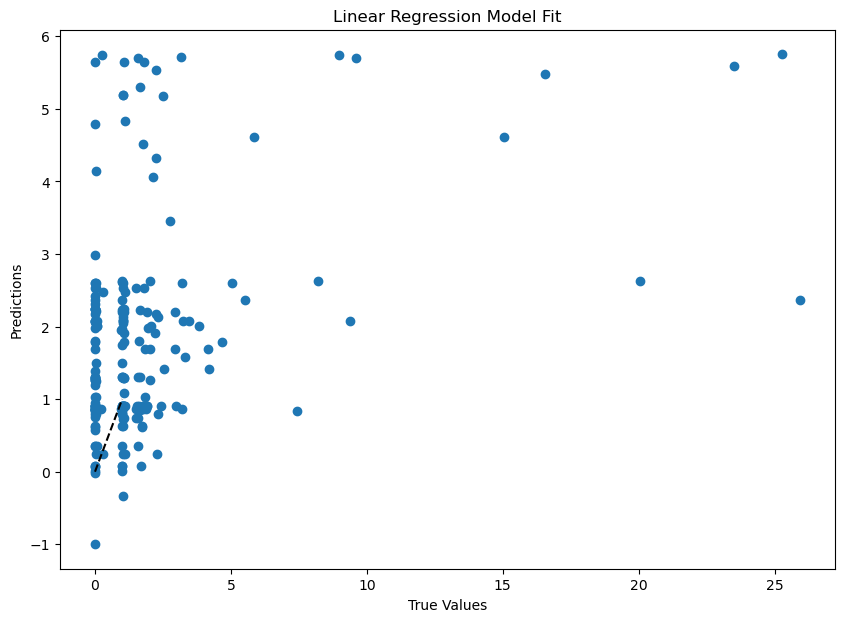

In [ ]:
# plot model fit with matplotlib
plt.figure(figsize=(10, 7))
plt.scatter(y, ols_results.fittedvalues)
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Model Fit')
plt.show()